In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))

In [14]:
# --- Load the Master Dataset ---
DATA_PATH = '../data/processed/features_master_dataset.csv'
df = pd.read_csv(DATA_PATH)

# --- Prepare Data for ML ---
# 1. Encode labels: Convert 'calm' and 'stress' to 0 and 1
df['label'] = df['label'].map({'calm': 0, 'stress': 1})

# 2. Define features (X) and target (y)
# We drop 'subject' as it's an identifier, not a feature for the model to learn
X = df.drop(['label', 'subject'], axis=1)
y = df['label']

print("Master dataset loaded and prepared:")
print(f"Total number of samples: {len(df)}")
print(f"Class distribution:\n{df['label'].value_counts(normalize=True)}")
display(X.head())

Master dataset loaded and prepared:
Total number of samples: 2160
Class distribution:
label
0    0.778704
1    0.221296
Name: proportion, dtype: float64


,scr_count,mean_scr_amplitude,gsr_mean,gsr_std,gsr_range,mean_hr,rmssd,sdnn,pnn50
0,5,0.043601,0.397778,0.037204,0.224417,74.818325,306.824533,240.572730,57.534247
1,3,0.025483,0.395624,0.035254,0.224417,77.362637,294.686576,234.772513,50.000000
2,0,0.000000,0.394509,0.034478,0.219094,80.799579,251.914888,213.196455,35.443038
3,0,0.000000,0.380959,0.008688,0.044596,84.006326,198.304071,192.294531,28.048780
4,0,0.000000,0.378745,0.002554,0.014800,86.450262,168.201041,161.388352,24.705882


In [15]:
# Split the data: 80% for training, 20% for testing
# stratify=y ensures both sets have a balanced representation of 'calm' and 'stress' samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (1728, 9)
Testing set shape: (432, 9)


In [16]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data to prevent information leakage
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

--- Evaluating Baseline Models (Before Tuning) ---

--- Support Vector Machine (Baseline) ---
Accuracy: 0.8380
Detailed baseline report saved to ../results/baseline_report_Support_Vector_Machine.txt


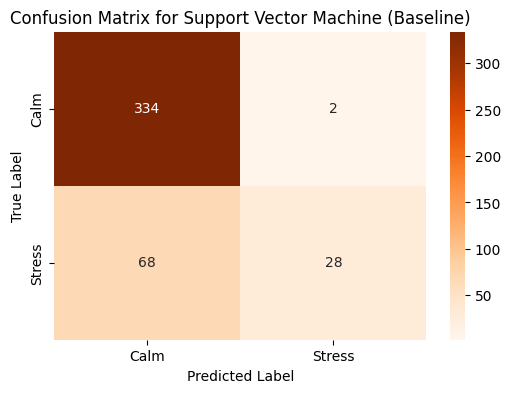


--- K-Nearest Neighbors (Baseline) ---
Accuracy: 0.9051
Detailed baseline report saved to ../results/baseline_report_K-Nearest_Neighbors.txt


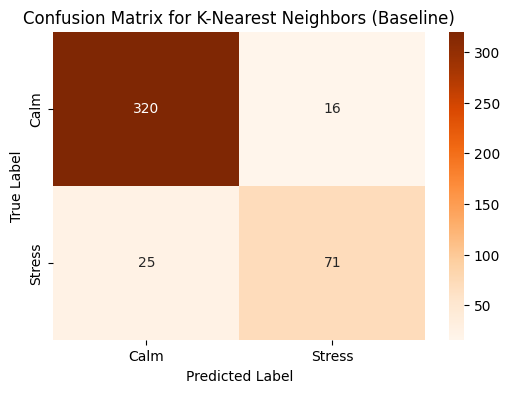


--- Decision Tree (Baseline) ---
Accuracy: 0.9491
Detailed baseline report saved to ../results/baseline_report_Decision_Tree.txt


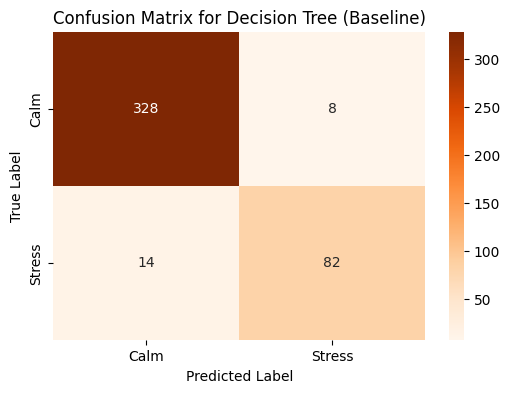



--- Starting Comprehensive Hyperparameter Tuning ---

>>> Tuning Model: Support Vector Machine
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters for Support Vector Machine: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

>>> Tuning Model: K-Nearest Neighbors
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Parameters for K-Nearest Neighbors: {'n_neighbors': 3, 'weights': 'distance'}

>>> Tuning Model: Decision Tree
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}


--- Evaluating Final Tuned Performance ---

--- Support Vector Machine (Tuned) ---
Accuracy: 0.9421
Detailed tuned report saved to ../results/tuned_report_Support_Vector_Machine.txt


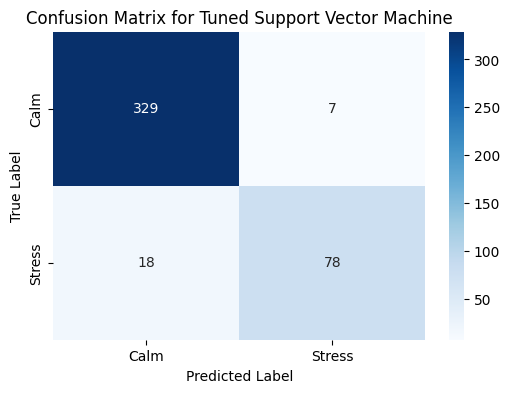


--- K-Nearest Neighbors (Tuned) ---
Accuracy: 0.9282
Detailed tuned report saved to ../results/tuned_report_K-Nearest_Neighbors.txt


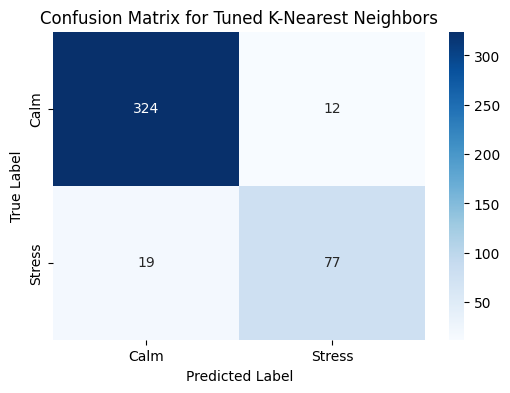


--- Decision Tree (Tuned) ---
Accuracy: 0.9537
Detailed tuned report saved to ../results/tuned_report_Decision_Tree.txt


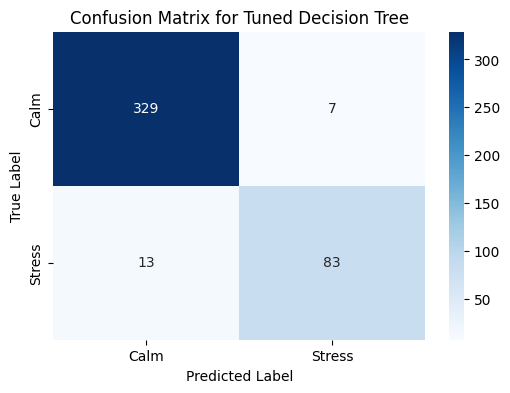


--- Final Model Performance Comparison ---
                    Model  Baseline Accuracy  Tuned Accuracy  Performance Gain
2           Decision Tree           0.949074        0.953704          0.004630
0  Support Vector Machine           0.837963        0.942130          0.104167
1     K-Nearest Neighbors           0.905093        0.928241          0.023148

Final comparison table saved to ../results/final_model_comparison.csv


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# --- 1. Setup ---
RESULTS_DIR = '../results/'
os.makedirs(RESULTS_DIR, exist_ok=True)
baseline_results = {}
tuned_results = {}

# --- 2. Train and Evaluate BASELINE Models ---
print("--- Evaluating Baseline Models (Before Tuning) ---")
baseline_models = {
    "Support Vector Machine": SVC(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

for name, model in baseline_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    baseline_results[name] = accuracy
    
    print(f"\n--- {name} (Baseline) ---")
    print(f"Accuracy: {accuracy:.4f}")

    # Save detailed classification report for the baseline model
    report = classification_report(y_test, y_pred, target_names=['Calm', 'Stress'])
    report_filename = f'{RESULTS_DIR}baseline_report_{name.replace(" ", "_")}.txt'
    with open(report_filename, 'w') as f:
        f.write(report)
    print(f"Detailed baseline report saved to {report_filename}")

    # Save confusion matrix for the baseline model
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
                xticklabels=['Calm', 'Stress'], yticklabels=['Calm', 'Stress'])
    plt.title(f'Confusion Matrix for {name} (Baseline)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'{RESULTS_DIR}baseline_cm_{name.replace(" ", "_")}.png', bbox_inches='tight')
    plt.show()

# --- 3. Perform Hyperparameter Tuning ---
print("\n\n--- Starting Comprehensive Hyperparameter Tuning ---")
models_to_tune = [
    { 'name': "Support Vector Machine", 'estimator': SVC(random_state=42), 'param_grid': { 'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}},
    { 'name': "K-Nearest Neighbors", 'estimator': KNeighborsClassifier(), 'param_grid': { 'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance']}},
    { 'name': "Decision Tree", 'estimator': DecisionTreeClassifier(random_state=42), 'param_grid': { 'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']}}
]
best_estimators = {}

for model_info in models_to_tune:
    name = model_info['name']; estimator = model_info['estimator']; param_grid = model_info['param_grid']
    print(f"\n>>> Tuning Model: {name}")
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    best_estimators[name] = grid_search.best_estimator_
    print(f"Best Parameters for {name}: {grid_search.best_params_}")

# --- 4. Evaluate TUNED Models ---
print("\n\n--- Evaluating Final Tuned Performance ---")
for name, model in best_estimators.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    tuned_results[name] = accuracy
    
    print(f"\n--- {name} (Tuned) ---")
    print(f"Accuracy: {accuracy:.4f}")

    # Save detailed classification report for the tuned model
    report = classification_report(y_test, y_pred, target_names=['Calm', 'Stress'])
    report_filename = f'{RESULTS_DIR}tuned_report_{name.replace(" ", "_")}.txt'
    with open(report_filename, 'w') as f:
        f.write(report)
    print(f"Detailed tuned report saved to {report_filename}")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Calm', 'Stress'], yticklabels=['Calm', 'Stress'])
    plt.title(f'Confusion Matrix for Tuned {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'{RESULTS_DIR}tuned_cm_{name.replace(" ", "_")}.png', bbox_inches='tight')
    plt.show()

# --- 5. Final Comparison Summary ---
print("\n--- Final Model Performance Comparison ---")
baseline_df = pd.DataFrame(list(baseline_results.items()), columns=['Model', 'Baseline Accuracy'])
tuned_df = pd.DataFrame(list(tuned_results.items()), columns=['Model', 'Tuned Accuracy'])
comparison_df = pd.merge(baseline_df, tuned_df, on='Model')
comparison_df['Performance Gain'] = comparison_df['Tuned Accuracy'] - comparison_df['Baseline Accuracy']
print(comparison_df.sort_values('Tuned Accuracy', ascending=False))

# Save the final comparison table
comparison_df.to_csv(f'{RESULTS_DIR}final_model_comparison.csv', index=False)
print(f"\nFinal comparison table saved to {RESULTS_DIR}final_model_comparison.csv")


--- Analyzing Feature Importance for the Best Model (Decision Tree) ---
Feature importance plot saved to ../results/feature_importance_dt.png


/tmp/ipykernel_26790/2926508926.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


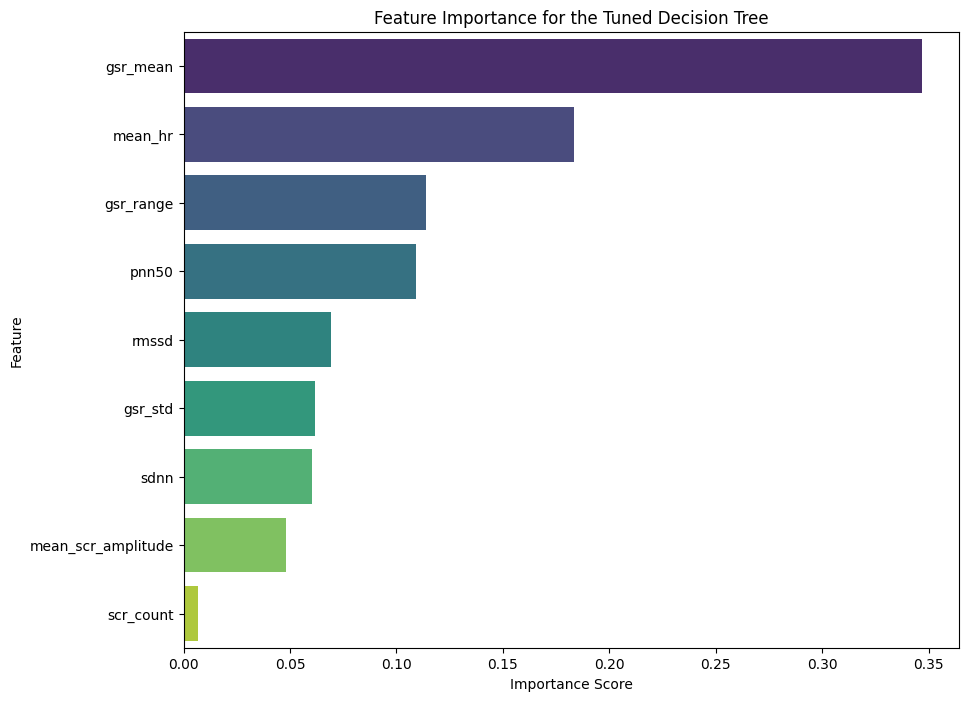

,feature,importance
2,gsr_mean,0.346661
5,mean_hr,0.183544
4,gsr_range,0.113812
8,pnn50,0.109056
6,rmssd,0.069469
3,gsr_std,0.061740
7,sdnn,0.060524
1,mean_scr_amplitude,0.048223
0,scr_count,0.006971


In [21]:
# --- 6. Analyze and Save Feature Importances for the Best Model ---

print("\n--- Analyzing Feature Importance for the Best Model (Decision Tree) ---")

# Get the best Decision Tree model from your dictionary of estimators
best_dt_model = best_estimators['Decision Tree']

# Get feature importances from the trained model
importances = best_dt_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance for the Tuned Decision Tree')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

# --- NEW: Save the figure ---
plt.savefig(f'{RESULTS_DIR}feature_importance_dt.png', bbox_inches='tight')
print(f"Feature importance plot saved to {RESULTS_DIR}feature_importance_dt.png")

plt.show()

display(feature_importance_df)